<a href="https://colab.research.google.com/github/Xixianghu202124213/Capstone/blob/main/Inventory2.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from tqdm import tqdm
import gym
import math
import random
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import collections

In [98]:
def data_split(data, train_percentage = 0.8):
    total = pd.to_datetime(data["ds"].unique(),format="%d.%m.%Y")
    train = int(len(total) * train_percentage)
    train_idx = total[0:train]
    test_idx = total[train:train+90]
    train_dataset = data.iloc[[date in train_idx for date in data['ds']],:]
    test_dataset = data.iloc[[date in test_idx for date in data['ds']],:]
    return train_dataset, test_dataset

In [99]:
data=pd.read_csv("/content/drive/MyDrive/Data/historical_orders.csv",sep = ';')
data["DATE"]=pd.to_datetime(data["DATE"],format="%d.%m.%Y")
data = data.rename(columns={'DATE': 'ds', 'QUANTITY': 'y','MATERIAL_NUMBER' :'product', 'PLANT': 'plant'})
data = data[data['ds'] < '2020-01-01']

#splite the test and train
train, test = data_split(data)
train, test = data_split(data)
pivot_train = pd.pivot_table(train, values='y', index=['product', 'plant'], columns=['ds'], aggfunc=np.mean)
train_series = pivot_train.iloc[8,:]
pivot_test = pd.pivot_table(test, values='y', index=['product', 'plant'], columns=['ds'], aggfunc=np.mean)
test_series = pivot_test.iloc[8,:]


In [100]:
pivot_test

ds             2019-01-01  2019-01-02  2019-01-03  2019-01-04  2019-01-05  \
product plant                                                               
A       X1              0         188         323         408           0   
        X2              0         634         549         336           0   
B       X1              0        3256        2117        1988           0   
        X2              0        3356        3572        4272           0   
C       X1              0          15           0          12           0   
D       X1              0         865         564         800           0   
        X2              0        6914       10349        9115           0   
E       X1              0        2028        4240        1863           0   
        X2              0        9933       11858       16904           0   
F       X1              0           0           0           0           0   
        X2              0           0           0           0           0   
G       X2              0           0           0           0           0   
H       X2              0         202          55           6          18   

ds             2019-01-06  2019-01-07  2019-01-08  2019-01-09  2019-01-10  \
product plant                                                               
A       X1              0           0         126         336         551   
        X2              0        3243         365        1269         276   
B       X1              0        1110        2002        1865         837   
        X2              0        2598        3317        3897        3790   
C       X1              0           1           0           2           0   
D       X1              0          84         289         337         994   
        X2              0       12858        2793        5692        4685   
E       X1              0         440        1583        1666        1885   
        X2             48       25365        5820       13085        6455   
F       X1              0           0           0           0           0   
        X2              0           0           0           0           0   
G       X2              0           0           0           0         624   
H       X2              0         258          15           2          13   

ds             ...  2019-03-22  2019-03-23  2019-03-24  2019-03-25  \
product plant  ...                                                   
A       X1     ...         306           0           0          98   
        X2     ...         676           0           0        2020   
B       X1     ...         617           0           0        2310   
        X2     ...        4023           0           0        4137   
C       X1     ...           0           0           0          19   
D       X1     ...         430           0           0         107   
        X2     ...       12253          48          48        2457   
E       X1     ...        1537           0           0         739   
        X2     ...        8965          48         384        6775   
F       X1     ...           0           0           0          87   
        X2     ...           0           0         232          25   
G       X2     ...           0           0           0           0   
H       X2     ...           0           0          90           0   

ds             2019-03-26  2019-03-27  2019-03-28  2019-03-29  2019-03-30  \
product plant                                                               
A       X1            245         622         155         386           0   
        X2            519         348        2290         520           0   
B       X1           2918        1835        1313         789           0   
        X2           3008        2799        3327        1454           0   
C       X1              0          30           0           3           0   
D       X1            463        1341         845        1465           0   
        X2           

#Environment

In [101]:
class Inventory(gym.Env):
  interval=0
  forecast=[]
  def __init__(self,leading_time,demand_list,space,emergency,holding_cost,trans_con=200,trans_unit=0.02,revenue=5):
    global interval
    global forecast
    interval=leading_time
    forecast=demand_list
    self.inv=0
    self.holding_cost=holding_cost
    self.trans_con=trans_con
    self.trans_unit=trans_unit
    self.queue=[0]*interval
    self.plan=forecast
    self.action_space=space
    self.revenue=revenue
    self.emergency=emergency
    self.penalty=0
    
  def add(self,amount):
    self.inv=self.queue[0]
    self.queue=self.queue[1:]+[amount]

  def send(self,amount):
    if self.inv>amount:
      self.inv-=amount
      return False #have enough stock
    else:
      self.inv=0
      #print("the inventory is not enough")
      return True #bankrupt

  def reset(self):
    self.inv=0
    self.queue=[0]*interval
    self.plan=forecast
    self.penalty=0
    return np.array([self.inv,np.sum(self.queue)])

  def select_action(self):
    if np.random.random()<self.emergency:
      demand=np.random.normal(np.mean(forecast),np.std(forecast))
    else:
      demand=self.plan[0]
    return demand

  def step(self,action):
    new_state = None
    state = np.array([self.inv, np.sum(self.queue)])
    done = False
    reward=0
    if action not in self.action_space:
      done=True
      print("action is not allowed")
    else:
      if action!=0:
        reward=self.trans_con

      self.add(action)
      current=self.inv

      demand=self.select_action()
      bankrupt=self.send(demand)
      self.plan=self.plan[1:]

      if len(self.plan)==1:
        done=True
      if bankrupt:
        reward+=self.trans_unit*action+self.holding_cost*self.inv+self.revenue*abs(demand-current)
        self.penalty+=self.revenue*np.abs(demand-current)
      else:
        reward+=self.trans_unit*action+self.holding_cost*self.inv

    new_state=np.array([self.inv,np.sum(self.queue)])
    return state,-reward,new_state,done
    

#Benchmark & Goal

In [102]:
def Benchmark(env):
  goal_total_reward=0
  goal_done=False
  
  penalty=0
  
  while not goal_done:
    minus=np.abs(np.asarray(env.action_space)-np.mean(env.plan)).tolist()
    id=minus.index(min(minus))
    goal_action=env.action_space[id] 
    goal_state, goal_reward, goal_new_state,goal_done= env.step(goal_action)
    goal_total_reward+=goal_reward
    
  penalty=env.penalty
  goal_state=env.reset()
  return goal_total_reward,penalty
def Goal(env):
  goal_reward=0
  done=False
  penalty=0
  while not done:
    try:
      minus=np.abs(np.asarray(env.action_space)-env.plan[leading_time]).tolist()
      id=minus.index((min(minus)))
      action=env.action_space[id]
    except:
      action=0
    
    state, reward, new_state,done= env.step(action)
    goal_reward+=reward
  penalty=env.penalty
  goal_state=env.reset()
  return goal_reward,penalty

#Dueling DQN

In [103]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity) 

    def add(self, state, action, reward, next_state, done): 
        self.buffer.append((state, action, reward, next_state, done)) 

    def sample(self, batch_size): 
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done 

    def size(self): 
        return len(self.buffer)

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))

def train_on_policy_agent(env, agent, num_episodes):
    return_list = []

    for i_episode in range(int(num_episodes)):
        episode_return = 0
        transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            transition_dict['states'].append(state)
            transition_dict['actions'].append(action)
            transition_dict['next_states'].append(next_state)
            transition_dict['rewards'].append(reward)
            transition_dict['dones'].append(done)
            state = next_state
            episode_return += reward
        return_list.append(episode_return)
        agent.update(transition_dict)

    return return_list

def train_off_policy_agent(env, agent, num_episodes, replay_buffer, minimal_size, batch_size):
    return_list = []
 
    for i_episode in range(int(num_episodes)):
        episode_return = 0
        state = env.reset()
        done = False
        while not done:
            action = agent.take_action(state)
            next_state, reward, done, _ = env.step(action)
            replay_buffer.add(state, action, reward, next_state, done)
            state = next_state
            episode_return += reward
            if replay_buffer.size() > minimal_size:
                b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                agent.update(transition_dict)
        return_list.append(episode_return)

          
    return return_list


def compute_advantage(gamma, lmbda, td_delta):
    td_delta = td_delta.detach().numpy()
    advantage_list = []
    advantage = 0.0
    for delta in td_delta[::-1]:
        advantage = gamma * lmbda * advantage + delta
        advantage_list.append(advantage)
    advantage_list.reverse()
    return torch.tensor(advantage_list, dtype=torch.float)

In [104]:
class VAnet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(VAnet, self).__init__()

        self.fc1=nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, hidden_dim)
        ) # 共享网络部分

        self.fc_A = nn.Sequential(
            nn.Linear(hidden_dim,64 ),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        ) 
        self.fc_V = nn.Sequential(
            nn.Linear(hidden_dim,64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) 

    def forward(self, x):
        A = self.fc_A(F.relu(self.fc1(x)))
        V = self.fc_V(F.relu(self.fc1(x)))
        Q = V + A - A.mean(1).view(-1, 1)  # Q值由V值和A值计算得到
        return Q


class DQN:
    ''' DQN算法,包括Double DQN和Dueling DQN '''
    def __init__(self,
                 state_dim,
                 hidden_dim,
                 action_dim,
                 learning_rate,
                 gamma,
                 epsilon,
                 target_update,
                 device,
                 dqn_type='VanillaDQN'):
        self.action_dim = action_dim
        if dqn_type == 'DuelingDQN':  # Dueling DQN采取不一样的网络框架
            self.q_net = VAnet(state_dim, hidden_dim,
                               self.action_dim).to(device)
            self.target_q_net = VAnet(state_dim, hidden_dim,
                                      self.action_dim).to(device)
        else:
            self.q_net = Qnet(state_dim, hidden_dim,
                              self.action_dim).to(device)
            self.target_q_net = Qnet(state_dim, hidden_dim,
                                     self.action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma
        self.epsilon = epsilon
        self.target_update = target_update
        self.count = 0
        self.dqn_type = dqn_type
        self.device = device

    def take_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
           # print("1111----11111")
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
           # print("2222-----22222")
        return action

    def max_q_value(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        return self.q_net(state).max().item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        #print(len(states))


        q_values = self.q_net(states).gather(1, actions)


        if self.dqn_type == 'DoubleDQN':
            max_action = self.q_net(next_states).max(1)[1].view(-1, 1)
            max_next_q_values = self.target_q_net(next_states).gather(
                1, max_action)
        else:
            max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
                -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))
        self.optimizer.zero_grad()
        dqn_loss.backward()
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(self.q_net.state_dict())
        self.count += 1
    def save_pass_models(self,num):
        path='/content/drive/MyDrive/Model/Pass/pass_model('+str(num)+').pt'
        torch.save(self.q_net.state_dict(),path)


    def save_great_models(self,title):
        path='/content/drive/MyDrive/Model/Great('+str(title)+').pt'
        torch.save(self.q_net.state_dict(),path)
 
    
        



In [105]:
def train_DQN(agent, env, num_episodes, replay_buffer, minimal_size,batch_size,bench_mark,goal,title):
    return_list = []
    max_q_value_list = []
    max_q_value = 0
    pass_list=[]
    great_list=[]
    x=0
    max=goal
    for i in range(10):
        with tqdm(total=int(num_episodes / 10),
                  desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    #print(state,"----")
                    action_id = agent.take_action(state)
                    
                    action=env.action_space[action_id]
                    max_q_value = agent.max_q_value(
                        state) * 0.005 + max_q_value * 0.995  # 平滑处理
                    max_q_value_list.append(max_q_value)  # 保存每个状态的最大Q值
                    
                    _, reward, next_state,done = env.step(action)
                    replay_buffer.add(state, action_id, reward, next_state, done)
                    
                    state = next_state
                    episode_return += reward
                    
                    if replay_buffer.size() > minimal_size:
                        
                        b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(
                            batch_size)
                        transition_dict = {
                            'states': b_s,
                            'actions': b_a,
                            'next_states': b_ns,
                            'rewards': b_r,
                            'dones': b_d
                        }
                        agent.update(transition_dict)
                    #print(state,"!!!!")
                return_list.append(episode_return)
                if episode_return>bench_mark:
                  #better than bench mark
                    pass_list.append(episode_return)

                if episode_return>max:
                    max=episode_return
                    x+=1
                    agent.save_great_models(title)
                    great_list.append(episode_return)

                
                if (i_episode + 1) % 10 == 0:
                    pbar.set_postfix({
                        'episode':
                        '%d' % (num_episodes / 10 * i + i_episode + 1),
                        'max_return':
                        '%.3f' % np.max(return_list[-i_episode:])
                    })
                pbar.update(1)
    return return_list, max_q_value_list,pass_list,great_list

#Train

In [106]:
def space_selct(test,leading_time,quantile):

  sum=[]
  j=0
  action=[]

  for i in range(len(test)):
    for length in range(leading_time):
      total=0
      if i+length<len(test):
        for j in range(length):
          total+=test[i+j]
        sum.append(total)

  for i in range(quantile):
    a=int(np.percentile(np.array(sum),i*100/quantile))
    if a not in action:
      action.append(a*i)
  return action

    
    

('F', 'X1') 9


Iteration 9: 100%|██████████| 500/500 [05:51<00:00,  1.42it/s, episode=5000, max_return=-5840.554]


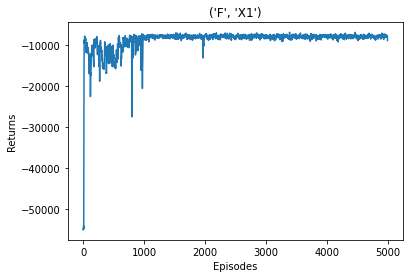

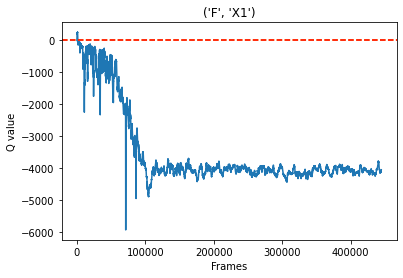

In [96]:
lr = .25e-3
num_episodes = 5000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 50
buffer_size = 50000
minimal_size = 1000
batch_size = 64
emergency_rate=0.01

leading_space=[12,12,12,12,19,12,12,12,12,12,12,12,19]
holding_cost=[0.05,0.05,0.1,0.1,0.05,0.1,0.1,0.05,0.05,0.1,0.1,0.05,0.1]
index=0

for title in pivot_test.index:
 

  if index==9:
    print(title,index)
    leading_time=leading_space[index]
    demand_list=pivot_test.loc[title]
    space=space_selct(demand_list,leading_time,20)


    env=Inventory(leading_time,demand_list,space,emergency_rate,holding_cost[index])
    bench,ben_pen=Benchmark(env)
    goal,goal_pen=Goal(env)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    state_dim = 2
    action_dim = len(env.action_space)

    random.seed(0)
    np.random.seed(0)


    torch.manual_seed(0)

    replay_buffer =ReplayBuffer(buffer_size)

    agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                target_update, device, 'DuelingDQN')
    return_list, max_q_value_list,pass_list,great_list = train_DQN(agent, env, num_episodes,replay_buffer, minimal_size,batch_size,bench,bench,title)

    episodes_list = list(range(len(return_list)))
    mv_return = moving_average(return_list, 5)
    plt.plot(episodes_list, mv_return)
    plt.title(str(title))
    plt.xlabel('Episodes')
    plt.ylabel('Returns')

    plt.show()

    frames_list = list(range(len(max_q_value_list)))
    plt.plot(frames_list, max_q_value_list)
    plt.axhline(0, c='orange', ls='--')
    plt.axhline(10, c='red', ls='--')
    plt.title(str(title))
    plt.xlabel('Frames')
    plt.ylabel('Q value')

    plt.show()
  index+=1


#Test

In [107]:
def test_DQN(agent,env, num_episodes,goal):
    return_list = []
    optimal_policy=[]
    optimal_inv=[]
    penalty=0

    max=goal
    for i_episode in range(num_episodes):
        episode_return = 0
        state = env.reset()
        done = False
        action_list=[]
        inventory_list=[]

        while not done:
            #print(state,"----")
            action_id = agent.take_action(state)   
            action=env.action_space[action_id]
            action_list.append(action)
            
            _, reward, next_state,done = env.step(action)
            state = next_state
            episode_return += reward
            inventory_list.append(state[0])

        return_list.append(episode_return)
        if episode_return>max:
          optimal_policy=action_list.copy()
          optimal_inv=inventory_list.copy()
          penalty=env.penalty
        
          '''
        if (i_episode + 1) % 10 == 0:
            print({
                'episode':
                '%d' % ( i_episode + 1),
                'return':
                '%.3f' % np.max(return_list[-10:])
            })
            '''
    return return_list,optimal_policy,optimal_inv,penalty

In [108]:
def plot_(demand_list,inv_list,action_list,titile,return_list):
  plt.plot(demand_list.index[0:89],inv_list,label = 'inv')
  plt.plot(demand_list.index[0:89],action_list,label='action')
  plt.plot(demand_list.index[0:89],demand_list[0:89],label='demand')
  plt.title(title)
  plt.plot()
  plt.legend()

  plt.plot(return_list)
  plt.title(title)


In [109]:
def plot_inv(demand_list,inv_list,action_list,titile):
  plt.plot(demand_list.index[0:89],inv_list,label = 'inv')
  #plt.plot(demand_list.index[0:89],action_list,label='action')
  plt.plot(demand_list.index[0:89],demand_list[0:89],label='demand')
  plt.title(title)
  plt.plot()
  plt.legend()

In [110]:
demand_list

ds
2019-01-01      0
2019-01-02      0
2019-01-03      0
2019-01-04      0
2019-01-05      0
             ... 
2019-03-27    289
2019-03-28    104
2019-03-29     35
2019-03-30      0
2019-03-31      0
Name: (F, X1), Length: 90, dtype: int64

In [111]:
lr = .25e-3
num_episodes = 5000
hidden_dim = 128
gamma = 0.99
epsilon = 0.01
target_update = 50
buffer_size = 50000
minimal_size = 1000
batch_size = 64


emergency_rate=0.01
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

leading_space=[12,12,12,12,19,12,12,12,12,12,12,12,19]
holding_cost=[0.05,0.05,0.1,0.1,0.05,0.1,0.1,0.05,0.05,0.1,0.1,0.05,0.1]
index=0

info=pd.DataFrame(columns=['reward','action','inv','penalty','goal','bench','goal_pen','ben_pen'])


for title in pivot_test.index:

  if index==9:
    demand_list=pivot_test.loc[title]
    leading_time=leading_space[index]
    demand_list=pivot_test.loc[title]
    space=space_selct(demand_list,leading_time,20)
    x=title
    


    env=Inventory(leading_time,demand_list,space,emergency_rate,holding_cost[index])
    bench,ben_pen=Benchmark(env)
    goal,goal_pen=Goal(env)

    state_dim = 2
    action_dim = len(env.action_space)

    agent1 = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
                target_update, device, 'DuelingDQN')
    agent1.q_net.load_state_dict(torch.load('/content/drive/MyDrive/Model/Great('+str(x)+').pt'))
    print(x)
    agent1.q_net.eval()

    return_list,action_list,inv_list,penalty= test_DQN(agent1, env, 500,bench)
    #plot_inv(demand_list,inv_list,action_list,title)

  # info.loc[title]=[return_list,action_list,inv_list,penalty,goal,bench,goal_pen,ben_pen]
  index+=1



('F', 'X1')


In [86]:
index==6
index==10
index==9

False

Text(0.5, 1.0, "('F', 'X1')")

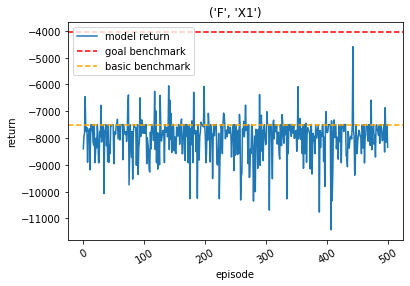

In [112]:
plt.plot(return_list,label='model return')

plt.axhline(goal, c='red', ls='--',label='goal benchmark')
plt.axhline(bench, c='orange', ls='--',label='basic benchmark')
plt.legend(loc='best')
plt.xlabel('episode')
plt.xticks(rotation=30)
plt.ylabel('return')
plt.title(x)

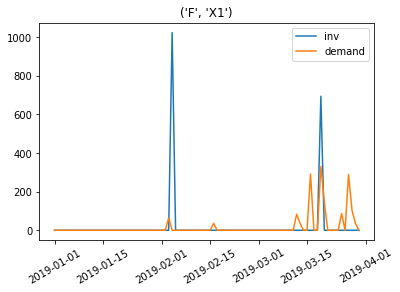

In [113]:
plt.plot(demand_list.index[0:89],inv_list,label = 'inv')
#plt.plot(demand_list.index[0:89],action_list,label='action')
plt.plot(demand_list.index[0:89],demand_list[0:89],label='demand')
plt.plot()
plt.title(x)
plt.xticks(rotation=30)
plt.legend(loc='best')

In [45]:
penalty

11190

In [ ]:
max(return_list)

-39924.29999999998

In [ ]:
len(inv_list)

89

In [ ]:
penalty

11110